## Load data

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [50]:
data = None
cumulative_within = True
cumulative_accross = !cumulative_within
if cumulative_within:
    indices = ["1_9", "10_19", "20_29"]
    for index in indices:
        fname = "results/predict-taskchar_result_cumulative_" + index + ".csv"
        new_data = pd.read_csv(fname)
        if data is not None:
            data = data.append(new_data, ignore_index=True)
        else:
            data = new_data
else:
    fname = "results/predict-taskchar_result_accross.csv"
    new_data = pd.read_csv(fname)
    if data is not None:
        data = data.append(new_data, ignore_index=True)
    else:
        data = new_data

In [51]:
data["AccuracyLow_sd"] = data["AccuracyLow_sd\""]
data = data.drop(labels=["AccuracyLow_sd\""],axis=1)
data["Userchar"] = data["[1] \"Userchar"]
data = data.drop(labels=["[1] \"Userchar"],axis=1)
for index, row in data.iterrows():
    data.iloc[index, -1] = row["Userchar"][5:]
    data.iloc[index, -2] = row["AccuracyLow_sd"][:-1]

In [52]:
data.head()

,WindowSize,Slice,Model,Repeat,Accuracy_mean,Accuracy_sd,Kappa_mean,Kappa_sd,AccuracyHigh_mean,AccuracyHigh_sd,AccuracyLow_mean,AccuracyLow_sd,Userchar
0,1000,1,MajorityClass,1,0.524752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,BarChartLit
1,1000,1,rf,1,0.526021,0.087867,0.073193,0.176155,0.473214,0.054583,0.571429,0.179379710900819,BarChartLit
2,1000,1,regLogistic,1,0.586365,0.104920,0.162823,0.210187,0.547619,0.126694,0.622642,0.15436985553389,BarChartLit
3,1000,1,xgbTree,1,0.537262,0.073644,0.083435,0.158260,0.520833,0.085328,0.555256,0.144545166404684,BarChartLit
4,1000,1,svmLinear,1,0.589588,0.091364,0.166028,0.166739,0.598214,0.128000,0.579515,0.116113663197261,BarChartLit


## General stats

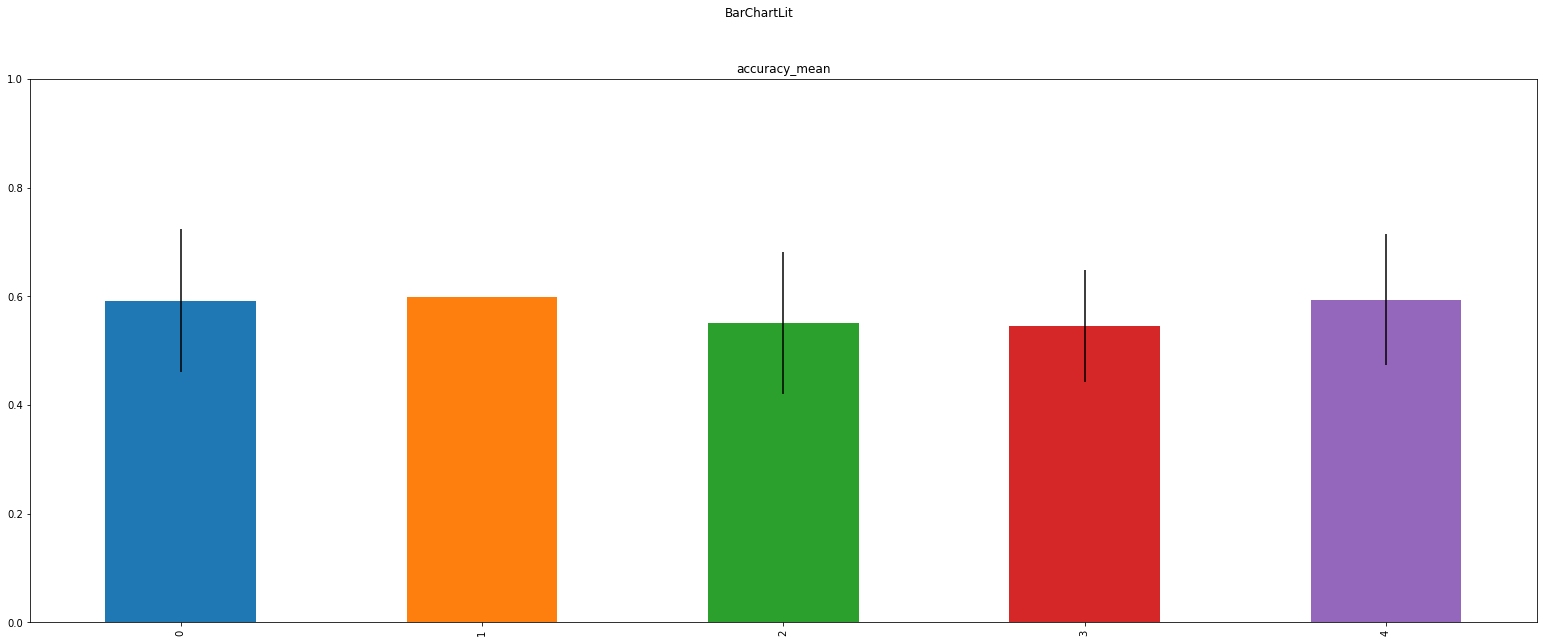

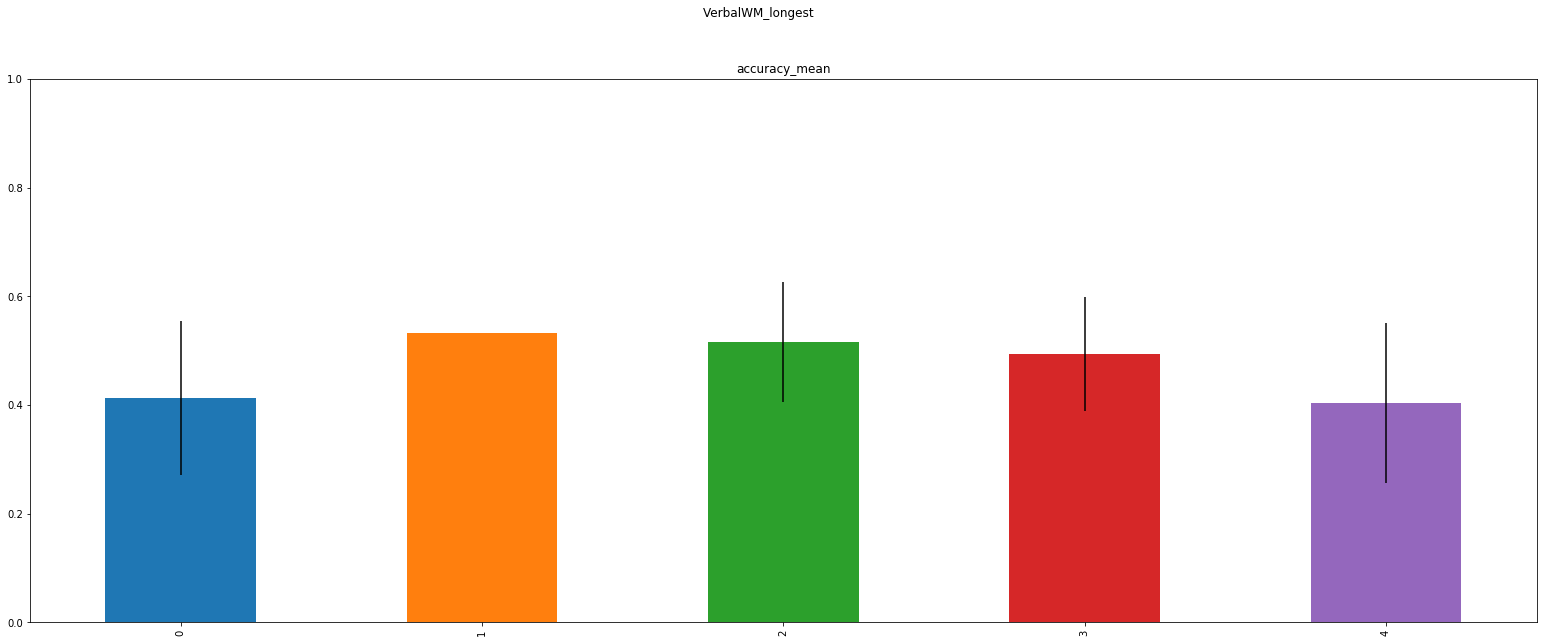

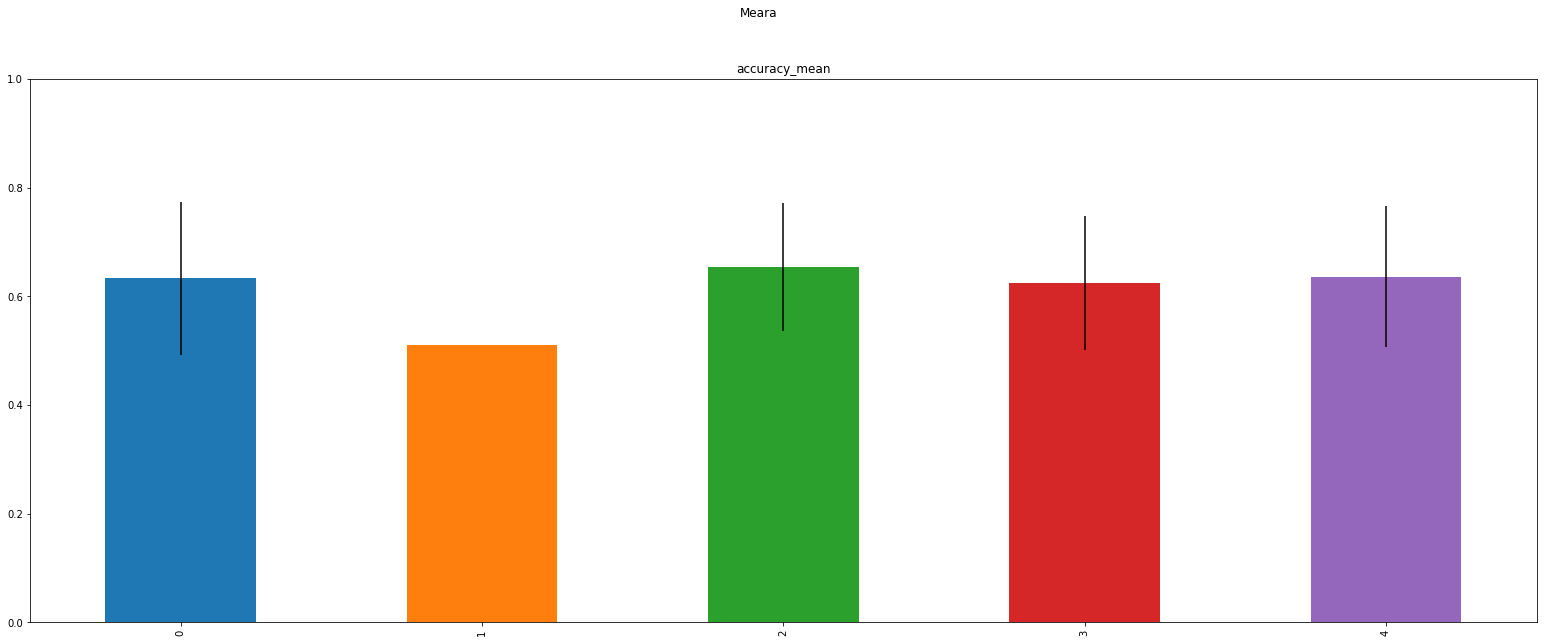

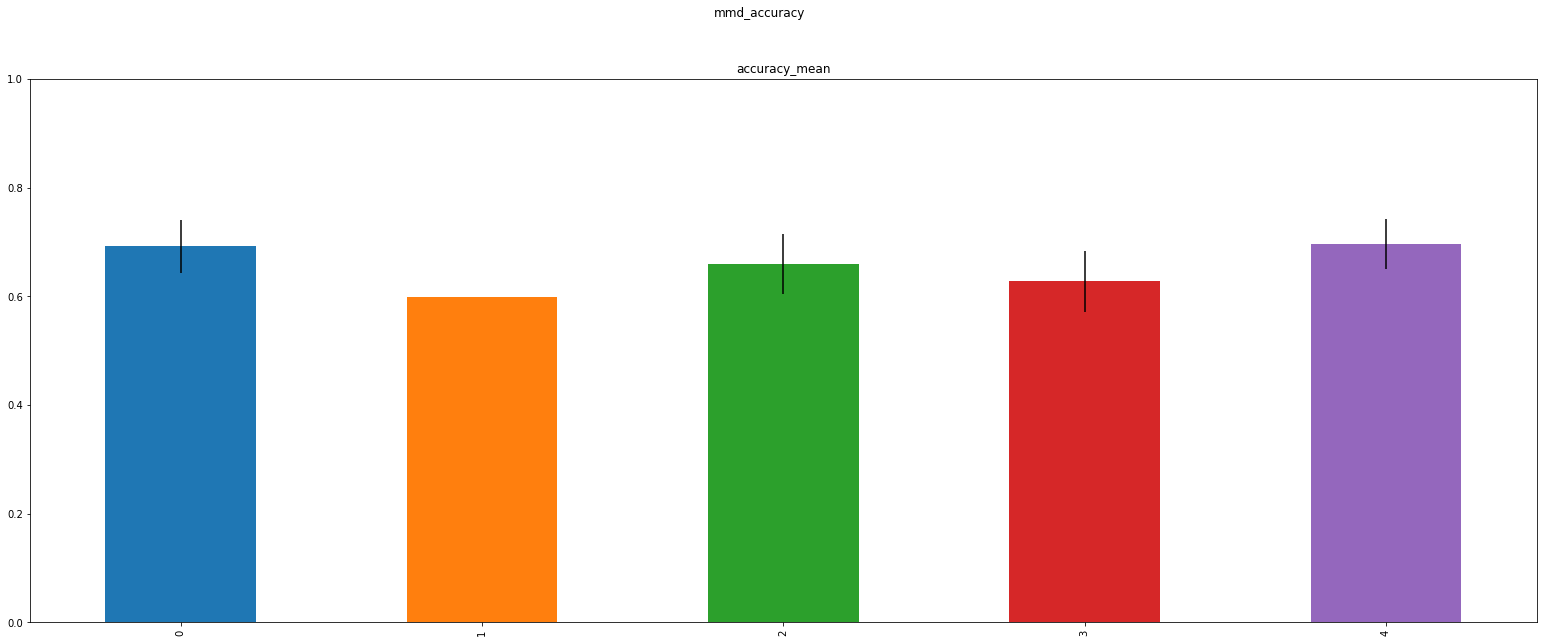

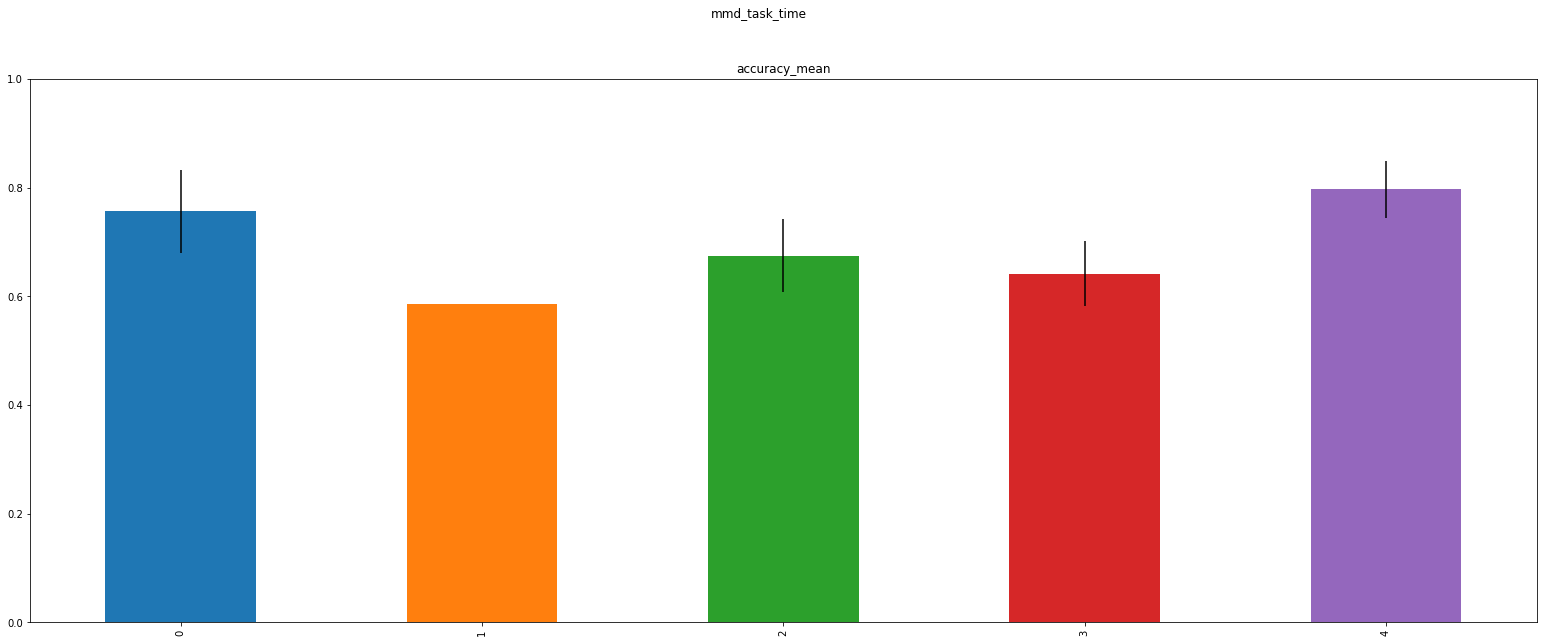

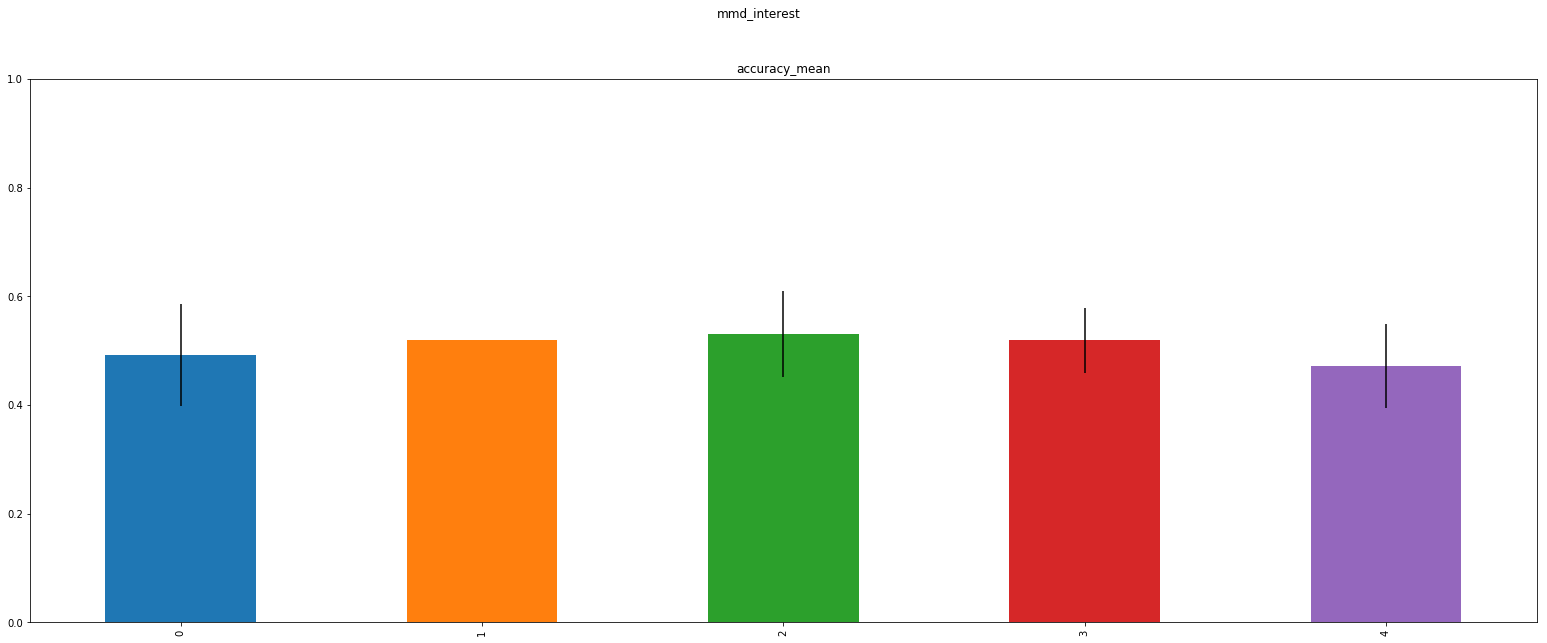

In [14]:
characteristics = ["BarChartLit", "VerbalWM_longest", "Meara", "mmd_accuracy", "mmd_task_time", "mmd_interest"]
windows = [2000]
for characteristic in characteristics:
    for window in windows:
        models = ["rf", "MajorityClass", "regLogistic", "SVMLinear", "xgbTree"]
        features = ["accuracy_mean"]
        
        fig, axes = plt.subplots()
        fig.suptitle(characteristic)

        for i, feature in enumerate(features):
            values = [[]]
            stderrs = []
            for model in models:
                idxmax = data.loc[(data["Userchar"] == characteristic) & (data["WindowSize"] == window)][model + "_" +feature].idxmax()
                max_row = data.iloc[idxmax]
                if (feature == "Slice"):
                    values[0].append(max_row[feature] * window)
                else:
                    values[0].append(max_row[model + "_" + feature])
                    stderrs.append(max_row[model + "_" + "accuracy_sd"])
            df2 = pd.DataFrame({"val": values[0],  "err": stderrs})
            means = df2["val"]
            plot = means.plot.bar(ax=axes, yerr=df2["err"], ylim=(0,1), title=feature, figsize=(27,10));
            figure = plot.get_figure()
            figure.savefig("/home/grigorii/Desktop/plots/full_window/" + characteristic + ".png")


## Accuracy over time

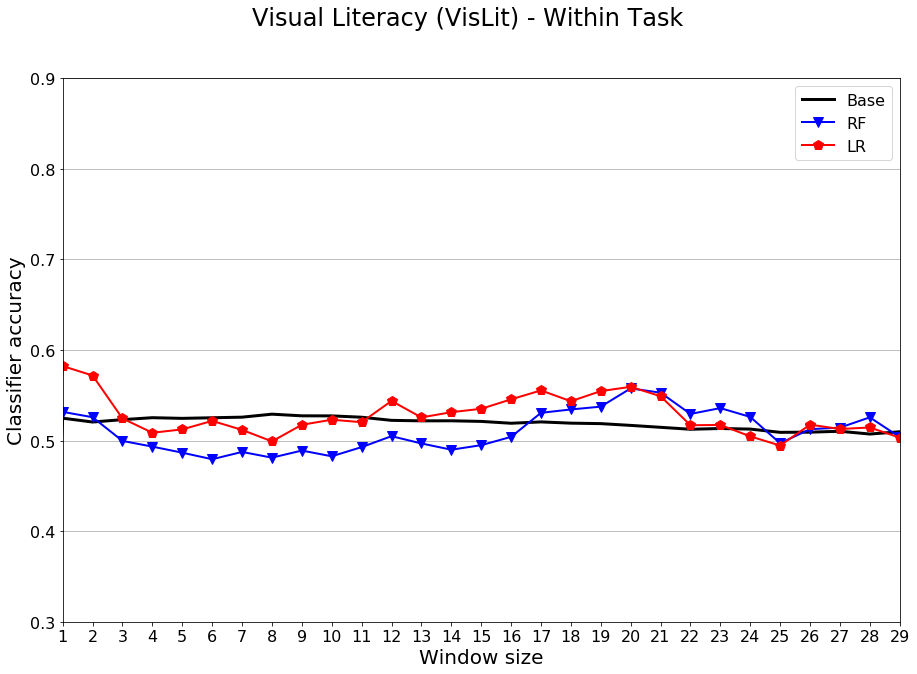

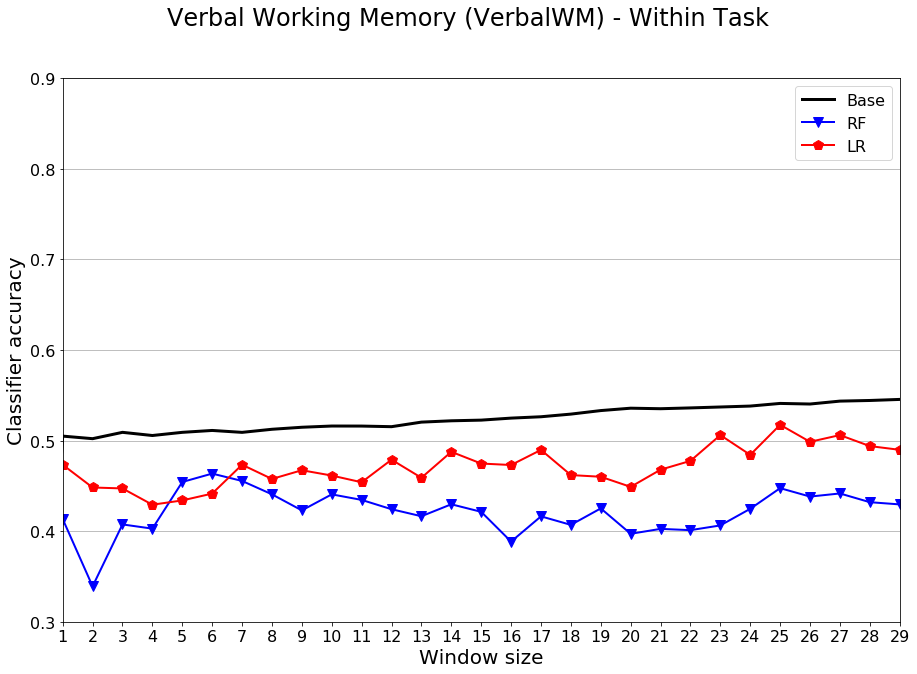

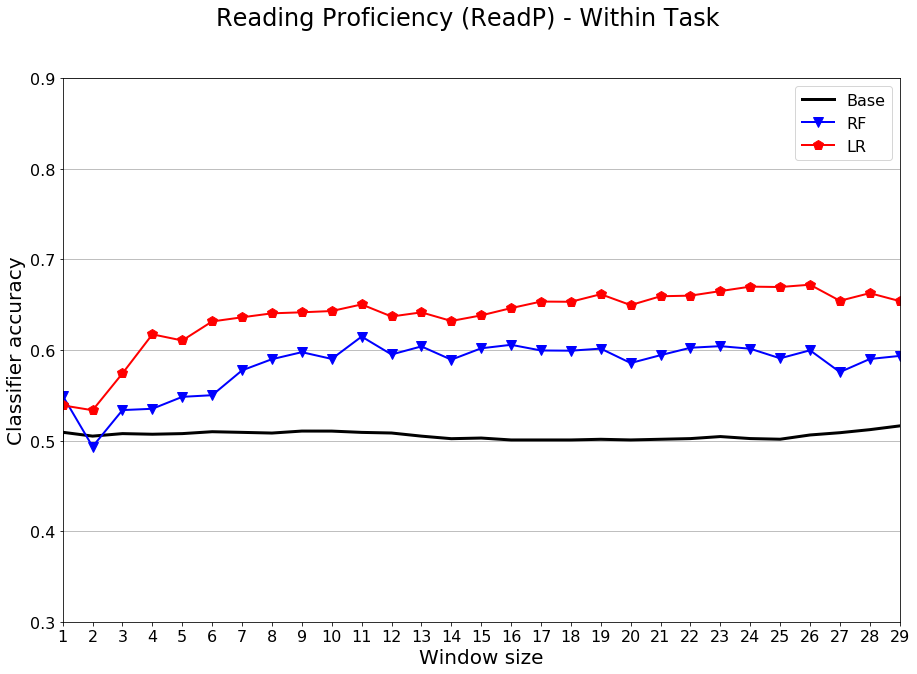

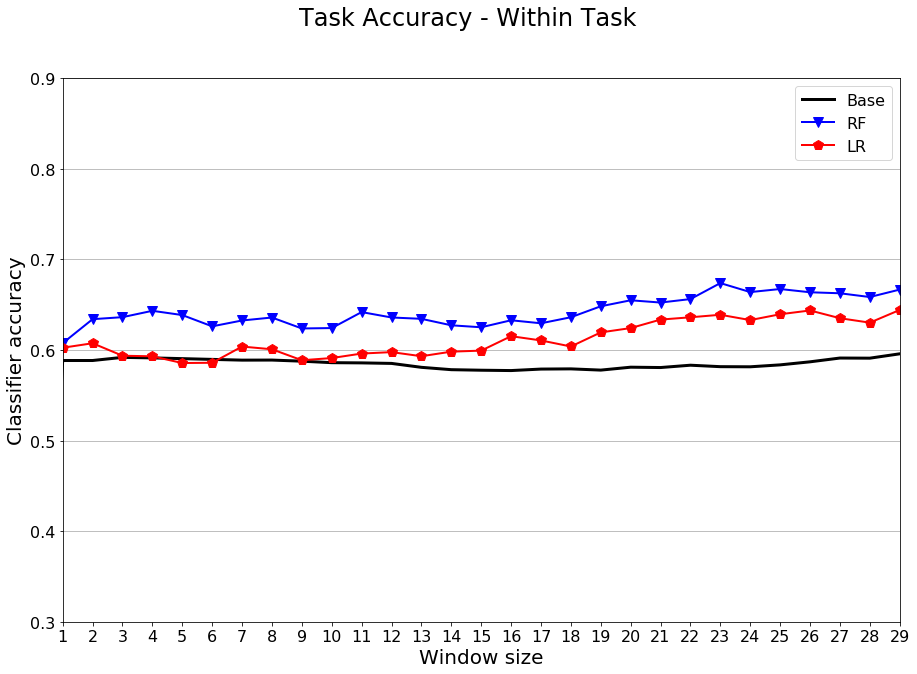

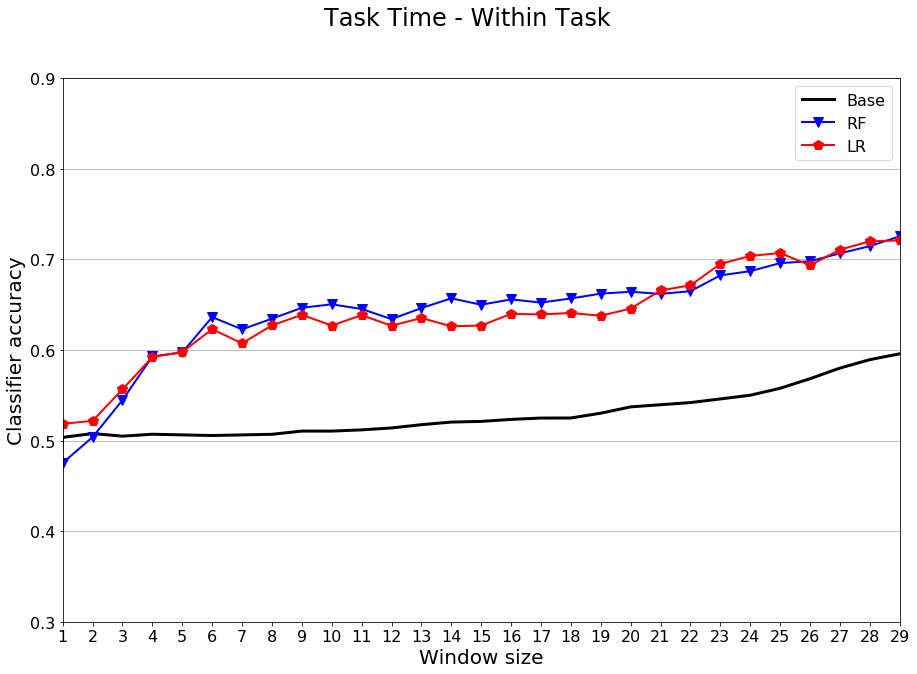

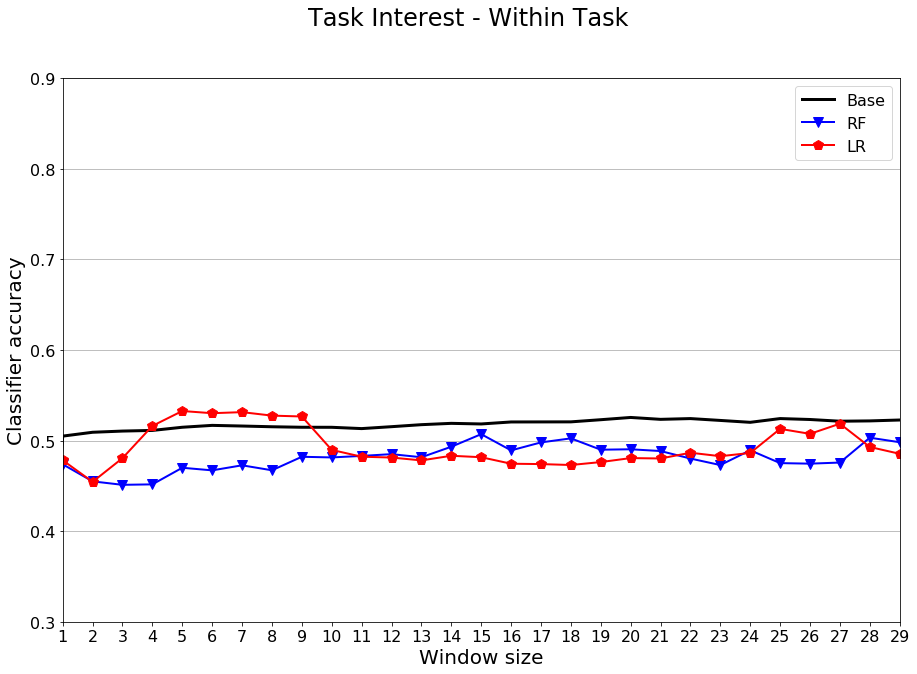

In [53]:
def map_char_name(char_name):
    if char_name == "BarChartLit":
        return "Visual Literacy (VisLit)"
    elif char_name == "VerbalWM_longest":
        return "Verbal Working Memory (VerbalWM)"
    elif char_name == "Meara":
        return "Reading Proficiency (ReadP)"
    elif char_name == "mmd_accuracy":
        return "Task Accuracy"
    elif char_name == "mmd_task_time":
        return "Task Time"
    else:
        return "Task Interest"

def map_classifier_name(class_name):
    if class_name == "MajorityClass":
        return "Base"
    elif class_name == "rf":
        return "RF"
    elif class_name == "regLogistic":
        return "LR"
    elif class_name == "svmLinear":
        return "SVM"
    else:
        return "XGB"

windows = [1000]
if cumulative_within:
    right_idx = 30 
    save_path = "/home/grigorii/Desktop/plots/cumulative_within/"
    characteristics = ["BarChartLit", "VerbalWM_longest", "Meara", "mmd_accuracy", "mmd_task_time", "mmd_interest"]

else:
    right_idx = 16
    save_path = "/home/grigorii/Desktop/plots/cumulative_across/"
    characteristics = ["BarChartLit", "VerbalWM_longest", "Meara"]

for characteristic in characteristics:
    for window in windows:
        #models = ["MajorityClass","rf", "regLogistic", "svmLinear", "xgbTree"]
        models = ["MajorityClass", "rf", "regLogistic",]

        features = ["Accuracy_mean"]
        for i, feature in enumerate(features):
            values = np.zeros(shape=(right_idx, len(models)))
            for timeslice in range(1, right_idx):
                for j, model in enumerate(models):
                    row = data.loc[(data["Userchar"] == characteristic) & (data["Slice"] == timeslice) & (data["Model"] == model)]
                    values[timeslice, j] = row[feature].mean()
            df2 = pd.DataFrame(values, columns=[map_classifier_name(model) for model in models])  
            styles=['k', 'b-v', 'r-p', 'y-D', 'm-o']
            lws = [3, 2, 2, 2, 2]
            plot = df2.plot(xticks=np.arange(1, right_idx, 1), xlim=(1, right_idx-1),ylim=(0.3, 0.9), figsize=(15,10), style=styles, markersize=10)
            for i, l in enumerate(plot.lines):
                plt.setp(l, linewidth=lws[i])            
            plot.set_xlabel("Window size", fontsize=20)
            plot.set_ylabel("Classifier accuracy", fontsize=20)
            plot.yaxis.grid(True)
            plot.legend(loc=1, prop={'size': 16})
            plt.tick_params(axis='both', which='major', labelsize=16)
            figure = plot.get_figure()
            title = map_char_name(characteristic)
            title = title + " - Within Task" if cumulative_within else title + " - Across Tasks"
            figure.suptitle(title, fontsize=24)
            figure.savefig(save_path + characteristic + ".png")

## Load Numbers Data

In [62]:
data = None
cumulative = False
full_window = False
if cumulative:
    fname = "results_nums/predict-taskchar_cumul_window_numbers.csv"
    data = pd.read_csv(fname)
elif full_window:
    data = pd.read_csv("results_nums/resultspredict-taskchar_fullwindow.csv")
else:
    fname = "results_nums/predict-taskchar_accoss_window_numbers.csv"
    data = pd.read_csv(fname)



In [64]:
data["NumDatapoints"] = data[" NumDatapoints\""]
data = data.drop(labels=[" NumDatapoints\""],axis=1)
data["WindowSize"] = data["[1] \"WindowSize"]
data = data.drop(labels=["[1] \"WindowSize"],axis=1)
for index, row in data.iterrows():
    data.iloc[index, -1] = row["WindowSize"][5:]
    data.iloc[index, -2] = int(row["NumDatapoints"][:-1])
    

In [65]:
data.head()

,Slice,NumDatapoints,WindowSize
0,1,54,1000
1,2,54,1000
2,3,53,1000
3,4,53,1000
4,5,53,1000
5,6,53,1000
6,7,53,1000
7,8,53,1000
8,9,53,1000
9,10,53,1000


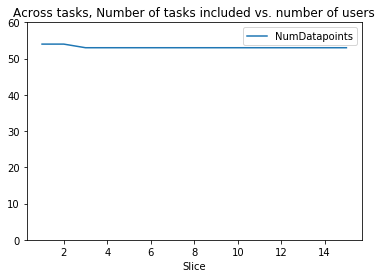

In [70]:
windows = [1000] 
for window in windows:
    plot = data.plot(x="Slice", y="NumDatapoints", ylim=(0, 60))
    figure = plot.get_figure()
    plt.title("Across tasks, Number of tasks included vs. number of users")
    figure.savefig("/home/grigorii/Desktop/plots/counts/accross.png")